In [1]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["GAUGE_GROUP"] = 'su2'

import sys
sys.path.append('..')

import numpy as np
from scipy.stats import unitary_group
from curraun.wong import init_charge

Using CUDA
Using SU(2)
Using double precision


In [3]:
# gell-mann matrices

gm = [
    [[0, 1, 0], [1, 0, 0], [0, 0, 0]],
    [[0, -1j, 0], [1j, 0, 0], [0, 0, 0]],
    [[1, 0, 0], [0, -1, 0], [0, 0, 0]],
    [[0, 0, 1], [0, 0, 0], [1, 0, 0]],
    [[0, 0, -1j], [0, 0, 0], [1j, 0, 0]],
    [[0, 0, 0], [0, 0, 1], [0, 1, 0]],
    [[0, 0, 0], [0, 0, -1j], [0, 1j, 0]],
    [[1 / np.sqrt(3), 0, 0], [0, 1 / np.sqrt(3), 0], [0, 0, -2 / np.sqrt(3)]]
]

T = np.array(gm) / 2.0

def init_charge(q0):
    """
        Step 1: specific random color vector
    """
    Q0 = np.einsum('ijk,i', T, q0)

    """
        Step 2: create a random SU(3) matrix to rotate Q.
    """
    
    V = unitary_group.rvs(3)
    detV = np.linalg.det(V)
    U = V / detV ** (1 / 3)
    Ud = np.conj(U).T

    Q = np.einsum('ab,bc,cd', U, Q0, Ud)

    """
        Step 3: Project onto color components
    """

    q = 2 * np.einsum('ijk,kj', T, Q)
    return np.real(q)

def init_charge_darboux():
    """
        Step 1: specific random color vector
    """
    # Values used to compute the SU(3) Casimirs
    # J1, J2 = 1, 0
    J1, J2 = 2.84801, 1.00841
    # Angle Darboux variables
    phi1, phi2, phi3 = np.random.uniform(), np.random.uniform(), np.random.uniform()
    # phi1, phi2, phi3 = np.random.uniform(0, 2*np.pi), np.random.uniform(0, 2*np.pi), np.random.uniform(0, 2*np.pi)

    search = True
    while search:
        pi2, pi3 = np.random.uniform(), np.random.uniform()
        pi1 = np.random.uniform(-pi3, pi3)

        numA = ((J1-J2)/3+pi3+pi2/np.sqrt(3))*((J1+2*J2)/3+pi3+pi2/np.sqrt(3))*((2*J1+J2)/3-pi3-pi2/np.sqrt(3))
        numB = ((J2-J1)/3+pi3-pi2/np.sqrt(3))*((J1+2*J2)/3-pi3+pi2/np.sqrt(3))*((2*J1+J2)/3+pi3-pi2/np.sqrt(3))

        if (numA>0) & (numB>0):
            search = False

    A = np.sqrt(numA)/(2*pi3)
    B = np.sqrt(numB)/(2*pi3)

    pip, pim = np.sqrt(pi3+pi1), np.sqrt(pi3-pi1)
    Cpp, Cpm, Cmp, Cmm = np.cos((phi1+np.sqrt(3)*phi2+phi3)/2), np.cos((phi1+np.sqrt(3)*phi2-phi3)/2), np.cos((-phi1+np.sqrt(3)*phi2+phi3)/2), np.cos((-phi1+np.sqrt(3)*phi2-phi3)/2)
    Spp, Spm, Smp, Smm = np.sin((phi1+np.sqrt(3)*phi2+phi3)/2), np.sin((phi1+np.sqrt(3)*phi2-phi3)/2), np.sin((-phi1+np.sqrt(3)*phi2+phi3)/2), np.sin((-phi1+np.sqrt(3)*phi2-phi3)/2)

    # Color charges
    Q1 = np.cos(phi1) * pip * pim
    Q2 = np.sin(phi1) * pip * pim
    Q3 = pi1
    Q4 = Cpp * pip * A + Cpm * pim * B
    Q5 = Spp * pip * A + Spm * pim * B
    Q6 = Cmp * pim * A - Cmm * pip * B
    Q7 = Smp * pim * A - Smm * pip * B
    Q8 = pi2
    q0 = np.array([Q1, Q2, Q3, Q4, Q5, Q6, Q7, Q8])
    
    Q0 = np.einsum('ijk,i', T, q0)

    """
        Step 2: create a random SU(3) matrix to rotate Q.
    """
    
    V = unitary_group.rvs(3)
    detV = np.linalg.det(V)
    U = V / detV ** (1 / 3)
    Ud = np.conj(U).T

    Q = np.einsum('ab,bc,cd', U, Q0, Ud)

    """
        Step 3: Project onto color components
    """

    q = 2 * np.einsum('ijk,kj', T, Q)
    return np.real(q)

    return q0

In [2]:
# q2=4, q3=10/9
# q0 = [0., 0., 0., 0., -1.69469, 0., 0., -1.06209]
# q2 = 1/3, q3=1/9
q0 = [0., 0., 0., 0., 0., 0., 0., -1/np.sqrt(3)]

def run_mc(N=10):
    Qa = np.zeros((3,))
    QaQb = np.zeros((3, 3))
    # perform MC integral
    for i in range(N):
        # q = init_charge(q0)
        q =  init_charge('fundamental')
        # q = init_charge_darboux()
        Qa += q
        QaQb += np.outer(q, q)
        # normalize
    Qa /= N
    QaQb /= N
    return Qa, QaQb

In [3]:
Qa, QaQb = run_mc(100000)
print('<Qa> = ' + str(np.round(Qa, 3)))
print('<Qa Qb> = \n' + str(np.round(QaQb, 3)))
print('<Qa Qb> (diagonal elements) = \n' + str(np.round(np.diagonal(QaQb), 3)))  
print('<Qa Qa> = ' + str(np.round(np.trace(QaQb), 3)))

<Qa> = [-0.001  0.    -0.   ]
<Qa Qb> = 
[[0.111 0.    0.   ]
 [0.    0.111 0.   ]
 [0.    0.    0.111]]
<Qa Qb> (diagonal elements) = 
[0.111 0.111 0.111]
<Qa Qa> = 0.333


In [8]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 10      
N = 512    
tau_sim = 1.0     
DTS = 8     

# Glasma
su_group = 'su3'
Qs = 2        
ns = 50    
factor = 0.8        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.1 * g**2 * mu         
uv = 10.0           

# Wong
mass = 10**8      
tau_form = 0     
pT = 0    
ntp = 10**5  
nevents = 1    
representation = 'fundamental'      
boundary = 'periodic'       

In [9]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

In [11]:
# Wong modules
from curraun import wong
wong.BOUNDARY = boundary
wong.CASIMIRS = True
from curraun.wong import init_mom_toy, init_pos

In [14]:
import pickle
from tqdm import tqdm

# Simulation routine
def simulate(q0, ev): 
    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    formt = int(tau_form / a * DTS)
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)
    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 5)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    masses = mass / E0 * np.ones(ntp)

    for i in range(ntp):
        x0, p0, q0 = init_pos(s.n), init_mom_toy('pT', pT / E0), init_charge(q0)
        x0s[i, :], p0s[i, :], q0s[i, :] = x0, p0, q0

    wong_solver.initialize(x0s, p0s, q0s, masses)

    mom_broad_T = np.zeros(maxt-formt)

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            # Solve Wong's equations
            if t>=formt:  
                mom_broad = wong_solver.p_sq_mean 
                mom_broad_T[t-formt] = (mom_broad[0] + mom_broad[1]) * E0**2

                wong_solver.evolve()
                wong_solver.compute_mom_broad()

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    return mom_broad_T

In [ ]:
q0s = [[0., 0., 0., 0., -1.69469, 0., 0., -1.06209], [0., 0., 0., 0., 0., 0., 0., -1/np.sqrt(3)]]
factors = [1/3, 4]

mom_broad_T = []

for q0 in q0s:
    mom_broads_T = []
    for ev in range(nevents):
        sim_mom_broad_T = simulate(q0, ev)
        mom_broads_T.append(sim_mom_broad_T)

    avg_mom_broad_T = np.mean(mom_broads_T, axis=0)
    mom_broad_T.append(avg_mom_broad_T)

formt, maxt = int(tau_form / L * N * DTS), int(tau_sim / L * N * DTS)
tau = np.linspace(tau_form, tau_sim, maxt-formt)

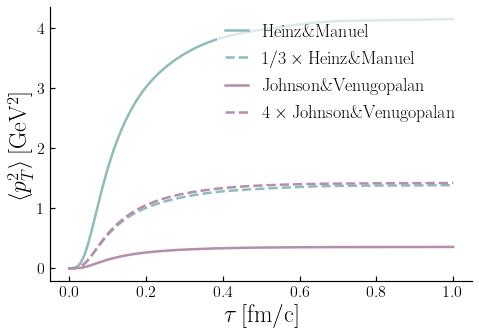

In [23]:
import matplotlib.pyplot as plt

plt.style.use('nord_theme_light.mpltstyle')
plt.rcParams["figure.figsize"] = (7,5)

fig = plt.figure()

plt.ylabel(r'$\langle p_T^2\rangle\,\mathrm{[GeV^2]}$')
plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$')

labels = [r'$\mathrm{Heinz\&Manuel}$', r'$\mathrm{Johnson\&Venugopalan}$']
labels_factors = [r'$1/3\times\mathrm{Heinz\&Manuel}$', r'$4\times\mathrm{Johnson\&Venugopalan}$']

colors = ['#8FBCBB', '#B48EAD']

ratio = {}
for i in range(len(q0s)):
    plt.plot(tau, mom_broad_T[i], label=labels[i], linewidth = 2.5, color=colors[i])
    plt.plot(tau, factors[i]*mom_broad_T[i], label=labels_factors[i], linewidth = 2.5, linestyle='--', color=colors[i])

# plt.ylim(0.5, 8.5)
# plt.xlim(0, 1)

plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('mom_broad_factors_fundamental.png', dpi=300, transparent=False, facecolor='white')

In [25]:
q0s = [[np.sqrt(24), 0., 0., 0., 0., 0., 0., 0.], [1/np.sqrt(9), 0., 0., 0., 0., 0., 0., 0.]]
factors = [1/8, 27]

mom_broad_T = []

for q0 in q0s:
    mom_broads_T = []
    for ev in range(nevents):
        sim_mom_broad_T = simulate(q0, ev)
        mom_broads_T.append(sim_mom_broad_T)

    avg_mom_broad_T = np.mean(mom_broads_T, axis=0)
    mom_broad_T.append(avg_mom_broad_T)

formt, maxt = int(tau_form / L * N * DTS), int(tau_sim / L * N * DTS)
tau = np.linspace(tau_form, tau_sim, maxt-formt)

Event 1: 100%|██████████| 409/409 [02:19<00:00,  2.93it/s]


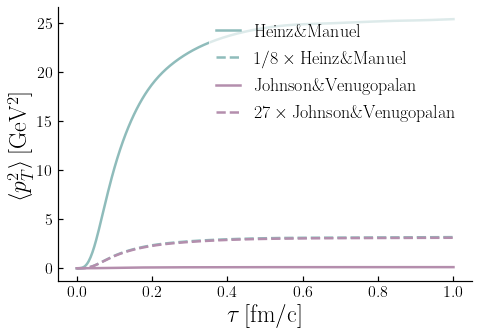

In [30]:
factors = [1/8, 27]
import matplotlib.pyplot as plt

plt.style.use('nord_theme_light.mpltstyle')
plt.rcParams["figure.figsize"] = (7,5)

fig = plt.figure()

plt.ylabel(r'$\langle p_T^2\rangle\,\mathrm{[GeV^2]}$')
plt.xlabel(r'$\tau\,\mathrm{[fm/c]}$')

labels = [r'$\mathrm{Heinz\&Manuel}$', r'$\mathrm{Johnson\&Venugopalan}$']
labels_factors = [r'$1/8\times\mathrm{Heinz\&Manuel}$', r'$27\times\mathrm{Johnson\&Venugopalan}$']

colors = ['#8FBCBB', '#B48EAD']

ratio = {}
for i in range(len(q0s)):
    plt.plot(tau, mom_broad_T[i], label=labels[i], linewidth = 2.5, color=colors[i])
    plt.plot(tau, factors[i]*mom_broad_T[i], label=labels_factors[i], linewidth = 2.5, linestyle='--', color=colors[i])

# plt.ylim(0.5, 8.5)
# plt.xlim(0, 1)

plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('mom_broad_factors_adjoint.png', dpi=300, transparent=False, facecolor='white')